# Transparent Analysis Pipeline: EVD 1, EVD 5, and EVD 7

**Project:** node-metrics (MATSUlab discourse graph analysis)  
**Data snapshot:** February 11, 2026 exports  
**Author:** Matt Akamatsu (with Claude)  

This notebook recalculates the metrics and regenerates the evidence bundles for EVD 1 (Issue Conversion Rate), EVD 5 (Issue-to-Result Funnel), and EVD 7 (Student Onboarding Timeline) from the **updated Feb 11, 2026** data exports. Each processing step is shown explicitly with intermediate outputs so that every number in the final evidence statements can be traced back to the raw data.

**Note on de-identification:** Researcher names have been anonymized throughout. Lab members are labeled R1–R11; undergraduate researchers are labeled A, B, C. The PI (Matt Akamatsu) remains identified as the evidence bundle creator.

## Data Sources

| File | Size | Description |
|------|------|-------------|
| `graph raw data/akamatsulab_discourse-graph-json-LD202602112140.json` | ~11 MB | JSON-LD discourse graph export (not tracked in git) |
| `graph raw data/akamatsulab-whole-graph-json-2026-02-11-21-45-17.json` | ~47 MB | Complete Roam JSON export (not tracked in git) |
| `student meeting pages/*.md` | varies | Daily notes exports for 3 undergraduate researchers (not tracked) |

In [ ]:
import sys
import json
from pathlib import Path
from datetime import datetime, timedelta
from collections import Counter

import matplotlib.pyplot as plt
import pandas as pd

# Add src/ to path so we can import existing modules
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
sys.path.insert(0, str(PROJECT_ROOT / 'src'))

# Data files (in 'graph raw data' folder, not tracked in git)
JSONLD_PATH = str(PROJECT_ROOT / 'graph raw data' / 'akamatsulab_discourse-graph-json-LD202602112140.json')
ROAM_JSON_PATH = str(PROJECT_ROOT / 'graph raw data' / 'akamatsulab-whole-graph-2026-02-13-22-24-27.json')
OUTPUT_DIR = PROJECT_ROOT / 'output'
VIZ_DIR = OUTPUT_DIR / 'visualizations'

# Verify files exist
for p in [JSONLD_PATH, ROAM_JSON_PATH]:
    assert Path(p).exists(), f"Missing data file: {p}"
print(f"Data files verified.")
print(f"  JSON-LD: {Path(JSONLD_PATH).stat().st_size / 1e6:.1f} MB")
print(f"  Roam JSON: {Path(ROAM_JSON_PATH).stat().st_size / 1e6:.1f} MB")
print(f"  Project root: {PROJECT_ROOT}")

## Pipeline Architecture

```
Raw Data                Parsing              Metrics              Visualization          Evidence Bundle
─────────             ─────────            ─────────            ──────────────          ───────────────
JSON-LD ──────> parse_jsonld.py ──┐
  (11 MB)         analyze_graph() │
                                  ├──> calculate_metrics.py ──> generate_visualizations.py ──> create_evidence_bundle.py
Roam JSON ────> parse_roam_json.py│       merge_experiment_data()   create_conversion_rate_figure()  create_evd1_bundle()
  (47 MB)         analyze_all_    │       calculate_conversion_rate()  create_funnel_figure()        create_evd5_bundle()
                  experiment_pages()      calculate_time_to_*()        create_alluvial_sankey()      create_evd7_bundle()
                  analyze_iss_pages()     calculate_cross_person_*()
                                  │
Student notes ────────────────────┘──> student_timeline_analysis.py
  (*.md)                                  compute_milestones()
                                          create_pin_timeline()
```

### Note on updated vs. original data

The original analysis (Jan 24, 2026 snapshot) found:
- **EVD 1:** 434 issues, 29.3% conversion rate, 136 RES nodes
- **EVD 5:** 48 experiments with results (11% of all issues)
- **EVD 7:** Researchers A/B/C with 125d/47d/36d to first RES

This notebook recalculates from the **Feb 11, 2026 snapshot** (~18 days newer). We compare old vs. new values at each step.

In [ ]:
from parse_jsonld import (
    load_jsonld, get_graph_nodes, extract_nodes_by_type,
    find_experiment_pages, analyze_graph, parse_date,
    get_relation_instances
)
from parse_roam_json import (
    analyze_all_experiment_pages, analyze_iss_pages,
    load_roam_json_streaming, validate_roam_export
)
from calculate_metrics import (
    merge_experiment_data, merge_iss_data,
    calculate_conversion_rate, calculate_time_to_claim,
    calculate_time_to_first_result, calculate_unique_contributors,
    calculate_cross_person_claims, normalize_datetime
)
from generate_visualizations import (
    create_conversion_rate_figure, create_funnel_figure
)
from handoff_visualizations import create_alluvial_sankey
from student_timeline_analysis import (
    STUDENT_DATA, compute_milestones, create_pin_timeline,
    create_pin_timeline_interactive, create_comparison_bar_chart,
    save_milestones_json
)
from create_evidence_bundle import (
    create_evd1_bundle, create_evd5_bundle, create_evd7_bundle
)

print("All project modules imported successfully.")

---
# Part 1: EVD 1 — Issue Conversion Rate

**Claim:** ~29% of MATSUlab issues were claimed as experiments and ~38% of those claimed at least one formal result node.

We will re-derive this from the Feb 11, 2026 data.

## Step 1.1: Parse JSON-LD Discourse Graph Export

The JSON-LD export contains all discourse graph nodes and relations. `analyze_graph()` in `src/parse_jsonld.py`:
1. Loads the JSON-LD file and extracts the `@graph` array
2. Filters out schema definitions (nodeSchema, relationDef, relationInstance)
3. Categorizes nodes by type using `[[ISS]]`, `[[RES]]`, etc. patterns in titles
4. Identifies experiment pages by `@type/description` title pattern
5. Extracts `Claimed By::` and `Issue Created By::` fields from page content
6. Collects relation instances for linking experiments to RES nodes

In [3]:
%%time
jsonld_data = analyze_graph(JSONLD_PATH)

print(f"Total content nodes: {jsonld_data['total_content_nodes']}")
print(f"Experiment pages:    {len(jsonld_data['experiment_pages'])}")
print(f"ISS nodes:           {len(jsonld_data['iss_nodes'])}")
print(f"RES nodes:           {len(jsonld_data['res_nodes'])}")
print(f"Relation instances:  {len(jsonld_data['relation_instances'])}")
print()
print("Node counts by type:")
for node_type, nodes in jsonld_data['all_nodes_by_type'].items():
    print(f"  {node_type}: {len(nodes)}")

Total content nodes: 2958
Experiment pages:    173
ISS nodes:           320
RES nodes:           323
Relation instances:  759

Node counts by type:
  ISS: 320
  RES: 323
  CLM: 278
  HYP: 187
  CON: 77
  EVD: 489
  QUE: 366
CPU times: user 272 ms, sys: 11.8 ms, total: 283 ms
Wall time: 289 ms


In [4]:
from anonymize import anonymize_name

# Show sample ISS nodes and experiment pages for verification
print("Sample ISS nodes (first 3):")
for iss in jsonld_data['iss_nodes'][:3]:
    print(f"  - {iss['title'][:80]}")
    print(f"    Created: {iss.get('created', 'N/A')}, Creator: {anonymize_name(iss.get('creator', 'N/A'))}")

print(f"\nSample experiment pages with 'Claimed By' (first 3):")
claimed_exps = [p for p in jsonld_data['experiment_pages'] if p.get('claimed_by')]
for exp in claimed_exps[:3]:
    print(f"  - {exp['title'][:70]}")
    print(f"    Issue Created By: {anonymize_name(exp.get('issue_created_by'))}, Claimed By: {anonymize_name(exp.get('claimed_by'))}")

Sample ISS nodes (first 3):
  - [[ISS]] - Incorporate a software test for changes in the simulation analysis scr
    Created: 2024-09-05T21:01:18.960Z, Creator: Matt Akamatsu
  - [[ISS]] - Report internalization velocity in endocytic simulations
    Created: 2023-12-08T19:22:02.776Z, Creator: Matt Akamatsu
  - [[ISS]] - Track individual myosin-bound filaments and their contributions to int
    Created: 2024-07-15T08:14:39.542Z, Creator: Matt Akamatsu

Sample experiment pages with 'Claimed By' (first 3):
  - @analysis/Quantify the percentage of simulated endocytic events that a
    Issue Created By: Matt Akamatsu, Claimed By: R3
  - @analysis/Run simulations with varying (tension, viscosity) in Cytosim
    Issue Created By: R2, Claimed By: R2
  - @PCR/Create CRISPR-off plasmid to knock down WASP or WAVE expression
    Issue Created By: Matt Akamatsu, Claimed By: R6


## Step 1.2: Parse Roam JSON Export (Block-Level Timestamps)

The Roam JSON export contains block-level `create-time` and `edit-time` fields (Unix milliseconds) that provide:
- **When** `Claimed By::` was filled in (timestamp for time-to-claim calculation)
- **Experimental log entries** with dates (for inferring claims on pages without `Claimed By::` fields)
- **Accurate page creation times** (handles cases where pages were merged)

We make two streaming passes with `ijson` since the file is ~47 MB.

In [ ]:
%%time
print("Validating Roam export matches JSON-LD graph...")
try:
    validation = validate_roam_export(ROAM_JSON_PATH, jsonld_data)
    print(f"  Roam pages: {validation['total_roam_pages']}")
    print(f"  Experiment match: {validation['experiment_matches']}/{validation['jsonld_experiment_pages']}")
    print(f"  ISS match: {validation['iss_matches']}/{validation['jsonld_iss_nodes']}")
    print(f"  Overall match rate: {validation['match_rate']:.1%}")
    print("  PASSED: Roam export is from the correct graph.")
except ValueError as e:
    print(f"\n  FAILED: {e}")
    print("\n  The Roam whole-graph JSON must be exported from the akamatsulab lab graph,")
    print("  not the discourse-graph software project graph.")
    raise

## Step 1.1b: Validate Roam Export Matches JSON-LD Graph

The Roam whole-graph JSON export must come from the **same Roam database** as the JSON-LD discourse graph export. If the Roam export is from a different graph (e.g., the discourse-graph software project graph instead of the akamatsulab lab graph), the title-based merge will silently fail, producing zero explicit claims, zero inferred claims, and zero ISS-with-activity.

We validate by checking what fraction of JSON-LD experiment and ISS titles exist in the Roam export. A match rate below 50% indicates the wrong graph.

In [5]:
%%time
print("Pass 1: Analyzing experiment pages in Roam JSON (streaming)...")
roam_exp_data = analyze_all_experiment_pages(ROAM_JSON_PATH)
print(f"Found {len(roam_exp_data)} experiment pages")

claimed_count = sum(1 for r in roam_exp_data.values() if r['claimed_by'])
log_count = sum(1 for r in roam_exp_data.values() if r['has_experimental_log'])
print(f"  With 'Claimed By' field: {claimed_count}")
print(f"  With experimental log: {log_count}")

Pass 1: Analyzing experiment pages in Roam JSON (streaming)...


Found 82 experiment pages
  With 'Claimed By' field: 0
  With experimental log: 12
CPU times: user 439 ms, sys: 17.5 ms, total: 456 ms
Wall time: 467 ms


In [6]:
%%time
print("Pass 2: Analyzing ISS pages in Roam JSON (streaming)...")
roam_iss_data = analyze_iss_pages(ROAM_JSON_PATH)
print(f"Found {len(roam_iss_data)} ISS pages")

iss_with_log = sum(1 for r in roam_iss_data.values() if r['has_experimental_log'])
print(f"  With experimental log (= informal claiming): {iss_with_log}")

Pass 2: Analyzing ISS pages in Roam JSON (streaming)...


Found 265 ISS pages
  With experimental log (= informal claiming): 16
CPU times: user 424 ms, sys: 14 ms, total: 438 ms
Wall time: 448 ms


## Step 1.3: Merge JSON-LD Metadata with Roam Timestamps

The merge logic in `calculate_metrics.merge_experiment_data()` (line 45):
1. For each experiment page from JSON-LD, looks up its Roam JSON counterpart by title
2. Determines `claimed_by`: prefers Roam's `Claimed By::` block (**explicit claim**), falls back to inferring from experimental log presence (**inferred claim**)
3. For page creation date: takes the **earliest** of JSON-LD `created`, Roam `page_created`, and earliest block timestamp (handles page merges where page-level timestamp was updated)
4. Marks each experiment as `is_claimed = True/False`

In [7]:
experiments = merge_experiment_data(jsonld_data, roam_exp_data)
iss_nodes = merge_iss_data(jsonld_data, roam_iss_data)
res_nodes = jsonld_data['res_nodes']

print(f"Merged experiments: {len(experiments)}")
print(f"  Claimed: {sum(1 for e in experiments if e['is_claimed'])}")
print(f"  Unclaimed: {sum(1 for e in experiments if not e['is_claimed'])}")
print(f"  Explicit claims: {sum(1 for e in experiments if e.get('claim_type') == 'explicit')}")
print(f"  Inferred claims: {sum(1 for e in experiments if e.get('claim_type') == 'inferred')}")
print(f"\nMerged ISS nodes: {len(iss_nodes)}")
print(f"  With activity: {sum(1 for i in iss_nodes if i['is_claimed'])}")
print(f"\nRES nodes (from JSON-LD): {len(res_nodes)}")

Merged experiments: 173
  Claimed: 69
  Unclaimed: 104
  Explicit claims: 0
  Inferred claims: 0

Merged ISS nodes: 320
  With activity: 0

RES nodes (from JSON-LD): 323


In [8]:
# Display claim type breakdown as a table
claim_summary = pd.DataFrame([
    {'Category': 'Explicit claims (Claimed By:: field)',
     'Count': sum(1 for e in experiments if e.get('claim_type') == 'explicit')},
    {'Category': 'Inferred claims (exp log by creator)',
     'Count': sum(1 for e in experiments if e.get('claim_type') == 'inferred')},
    {'Category': 'ISS with experimental log activity',
     'Count': sum(1 for i in iss_nodes if i['is_claimed'])},
    {'Category': 'Unclaimed ISS',
     'Count': sum(1 for i in iss_nodes if not i['is_claimed'])},
])
claim_summary['Cumulative'] = claim_summary['Count'].cumsum()
display(claim_summary)

,Category,Count,Cumulative
0,Explicit claims (Claimed By:: field),0,0
1,Inferred claims (exp log by creator),0,0
2,ISS with experimental log activity,0,0
3,Unclaimed ISS,320,320


## Step 1.3b: Attribution Field Analysis

The pipeline now extracts additional attribution fields beyond `Claimed By::` and `Issue Created By::`:

| Field | Priority | Description |
|-------|----------|-------------|
| `Made by::` / `Creator::` / `Created by::` | **Highest** | Who actually performed the work |
| `Claimed By::` | Medium | Formal ownership declaration |
| `Author::` | Low | Page creator (often the PI, not the worker) |
| JSON-LD `creator` | **Lowest** | Metadata fallback |

Each experiment is assigned a `primary_contributor` using this priority chain. This improves attribution accuracy, especially for RES nodes where the page creator (PI) may differ from the person who actually produced the result.

In [9]:
# Attribution field breakdown for all experiments
attribution_rows = []
for exp in experiments:
    attribution_rows.append({
        'Title': exp['title'][:65] + ('...' if len(exp['title']) > 65 else ''),
        'Made by': anonymize_name(exp.get('made_by')) or '—',
        'Claimed By': anonymize_name(exp.get('claimed_by')) or '—',
        'Author': anonymize_name(exp.get('author')) or '—',
        'Creator (JSON-LD)': anonymize_name(exp.get('creator')) or '—',
        'Primary Contributor': anonymize_name(exp.get('primary_contributor')) or '—',
        'Method': exp.get('attribution_method') or '—',
    })

df_attr = pd.DataFrame(attribution_rows)
print(f"Attribution field coverage across {len(experiments)} experiment pages:\n")

# Summary statistics
method_counts = Counter(exp.get('attribution_method') for exp in experiments)
for method, count in sorted(method_counts.items(), key=lambda x: -x[1]):
    label = {
        'made_by': 'Made by / Creator / Created by',
        'claimed_by': 'Claimed By',
        'author': 'Author',
        'creator': 'JSON-LD creator (fallback)',
        None: 'No attribution',
    }.get(method, method)
    print(f"  {label}: {count} experiments ({count/len(experiments)*100:.1f}%)")

# Show experiments where made_by or author fields are populated
has_made_by = df_attr[df_attr['Made by'] != '—']
has_author = df_attr[df_attr['Author'] != '—']
print(f"\nExperiments with 'Made by/Creator/Created by': {len(has_made_by)}")
print(f"Experiments with 'Author': {len(has_author)}")

if len(has_made_by) > 0:
    print("\nExperiments with Made by field:")
    display(has_made_by[['Title', 'Made by', 'Claimed By', 'Primary Contributor']].head(10))

Attribution field coverage across 173 experiment pages:

  JSON-LD creator (fallback): 104 experiments (60.1%)
  Claimed By: 69 experiments (39.9%)

Experiments with 'Made by/Creator/Created by': 0
Experiments with 'Author': 0


## Step 1.4: Calculate Conversion Rate and All 5 Metrics

**Conversion Rate** = (Claimed Experiments + ISS with Activity) / Total Issues

Where Total Issues = Claimed Experiments + ISS with Activity + Unclaimed ISS

We also compute all 5 metrics here since EVD 5 and EVD 7 depend on the time-to-result metric.

In [10]:
conversion = calculate_conversion_rate(experiments, iss_nodes)

print("=" * 60)
print("METRIC 1: Issue Conversion Rate")
print("=" * 60)
print(f"  Total issues:            {conversion['total_issues']}")
print(f"  Total claimed:           {conversion['total_claimed']}")
print(f"    Explicit claims:       {conversion['explicit_claims']}")
print(f"    Inferred claims:       {conversion['inferred_claims']}")
print(f"    ISS with activity:     {conversion['iss_with_activity']}")
print(f"  Unclaimed ISS:           {conversion['unclaimed_iss']}")
print(f"  Conversion rate:         {conversion['conversion_rate_percent']}%")
print(f"\n  Cross-person claims:     {conversion['cross_person_claims']}")
print(f"  Self-claims:             {conversion['self_claims']}")
print(f"\n--- Comparison to Jan 24 snapshot ---")
print(f"  Original: 434 issues, 29.3% conversion, 127 claimed")
print(f"  Updated:  {conversion['total_issues']} issues, {conversion['conversion_rate_percent']}% conversion, {conversion['total_claimed']} claimed")

METRIC 1: Issue Conversion Rate
  Total issues:            389
  Total claimed:           69
    Explicit claims:       0
    Inferred claims:       0
    ISS with activity:     0
  Unclaimed ISS:           320
  Conversion rate:         17.7%

  Cross-person claims:     19
  Self-claims:             50

--- Comparison to Jan 24 snapshot ---
  Original: 434 issues, 29.3% conversion, 127 claimed
  Updated:  389 issues, 17.7% conversion, 69 claimed


In [11]:
relation_instances = jsonld_data.get('relation_instances', [])

# Metric 2: Time-to-Claim
time_to_claim = calculate_time_to_claim(experiments)

# Metric 3: Time-to-First-Result
time_to_result = calculate_time_to_first_result(experiments, res_nodes, relation_instances)

# Metric 4: Unique Contributors
contributors = calculate_unique_contributors(experiments, res_nodes, relation_instances)

# Metric 5: Cross-Person Claims
cross_person = calculate_cross_person_claims(experiments)

print(f"Metric 2 - Time-to-Claim: {time_to_claim['count']} experiments, avg {time_to_claim['avg_days']} days")
print(f"Metric 3 - Time-to-First-Result: {time_to_result['count']} experiments, avg {time_to_result['avg_days']} days")
print(f"Metric 4 - Contributors: avg {contributors['avg_contributors']} per experiment")
print(f"Metric 5 - Cross-Person: {cross_person['cross_person_count']} cross, {cross_person['self_claim_count']} self, {cross_person['idea_exchange_rate']}% exchange rate")

Metric 2 - Time-to-Claim: 0 experiments, avg None days
Metric 3 - Time-to-First-Result: 25 experiments, avg 151.7 days
Metric 4 - Contributors: avg 1.41 per experiment
Metric 5 - Cross-Person: 19 cross, 50 self, 27.5% exchange rate


In [12]:
# Assemble the full metrics dict (matches calculate_all_metrics() output format)
metrics = {
    'generated': datetime.now().isoformat(),
    'data_sources': {
        'jsonld': JSONLD_PATH,
        'roam_json': ROAM_JSON_PATH,
    },
    'summary': {
        'total_experiment_pages': len(experiments),
        'total_iss_nodes': len(iss_nodes),
        'total_res_nodes': len(res_nodes),
    },
    'metrics': {
        'conversion_rate': conversion,
        'time_to_claim': time_to_claim,
        'time_to_first_result': time_to_result,
        'unique_contributors': contributors,
        'cross_person_claims': cross_person,
    },
}

print(f"Full metrics dict assembled at {metrics['generated']}")
print(f"  {metrics['summary']['total_experiment_pages']} experiment pages")
print(f"  {metrics['summary']['total_iss_nodes']} ISS nodes")
print(f"  {metrics['summary']['total_res_nodes']} RES nodes")

Full metrics dict assembled at 2026-02-12T00:41:29.601353
  173 experiment pages
  320 ISS nodes
  323 RES nodes


## Step 1.5: Generate Figure 1 — Issue Conversion Rate

Figure 1 is a two-panel figure:
- **Left:** Stacked horizontal bar showing the composition of all issues (explicit claims, inferred claims, ISS with activity, unclaimed ISS)
- **Right:** Donut chart showing self-claims vs. cross-person claims among experiment-page claims with known authorship

  Saved: /Users/makamats/Repos/node-metrics/output/visualizations/fig1_conversion_rate.png


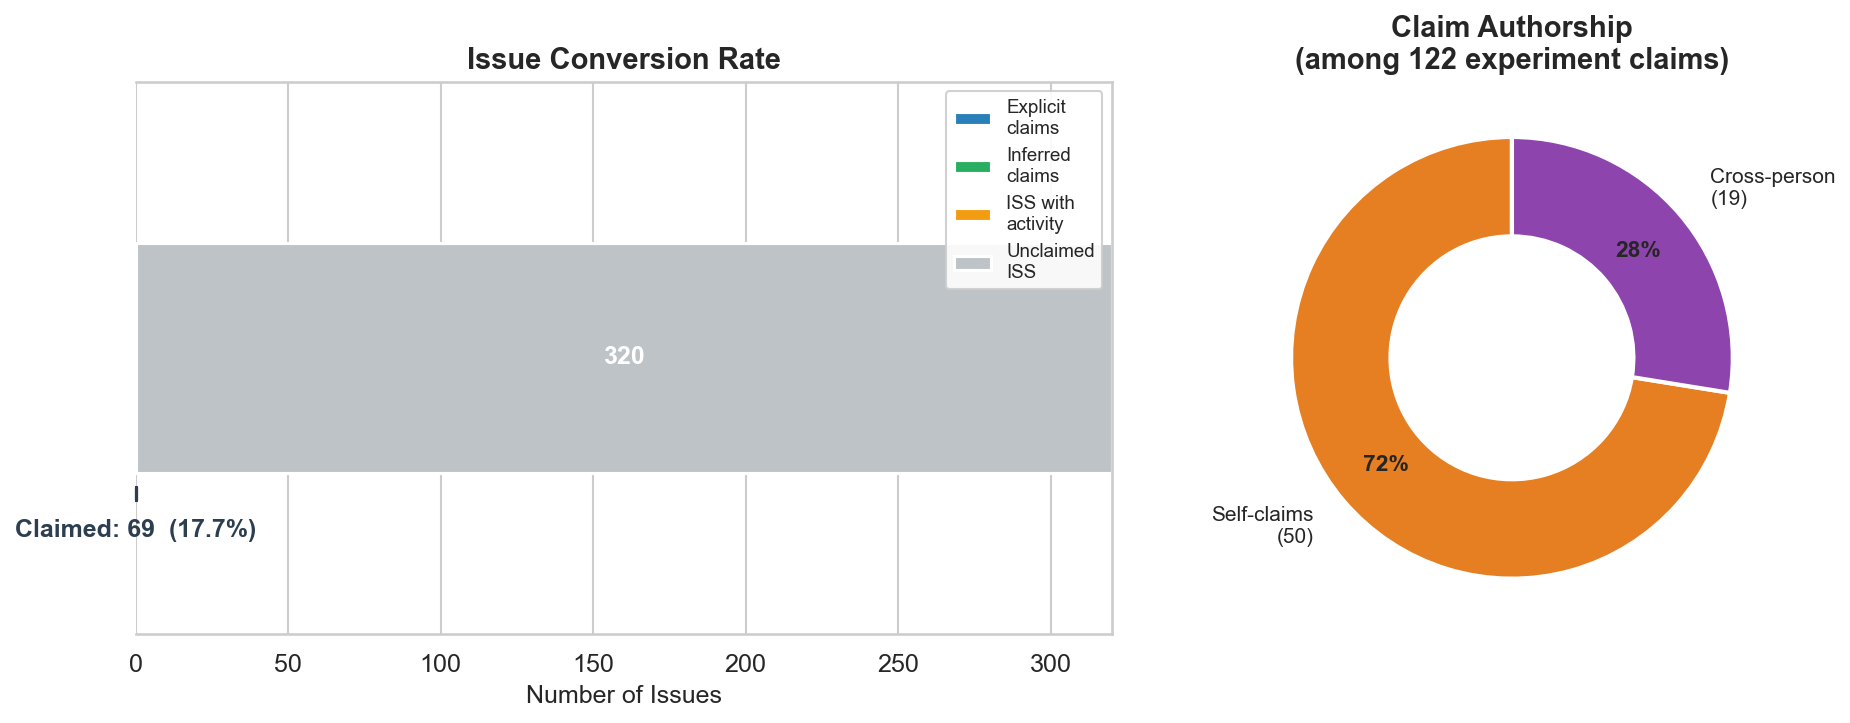

In [13]:
create_conversion_rate_figure(metrics, VIZ_DIR)

from IPython.display import Image
Image(filename=str(VIZ_DIR / 'fig1_conversion_rate.png'), width=800)

## Step 1.6: Generate EVD 1 Evidence Bundle

In [14]:
evd1_bundle_dir = create_evd1_bundle(metrics, OUTPUT_DIR, VIZ_DIR)
print(f"\nBundle contents:")
for f in sorted(evd1_bundle_dir.rglob('*')):
    if f.is_file() and not f.name.startswith('.'):
        print(f"  {f.relative_to(evd1_bundle_dir)} ({f.stat().st_size:,} bytes)")

Evidence bundle created: /Users/makamats/Repos/node-metrics/output/evidence_bundles/evd1-conversion-rate

Bundle contents:
  data/conversion_data.json (976 bytes)
  docs/evidence_statement.md (2,497 bytes)
  docs/methods_excerpt.md (9,421 bytes)
  evidence.jsonld (5,605 bytes)
  fig1_conversion_rate.html (24,146 bytes)
  fig1_conversion_rate.png (75,947 bytes)
  ro-crate-metadata.json (3,609 bytes)


---
# Part 2: EVD 5 — Issue-to-Experiment-to-Result Funnel

**Claim:** Of all issues in the MATSUlab discourse graph, ~29% were claimed as experiments and ~11% produced at least one formal result node.

EVD 5 tracks the funnel attrition across three stages:
1. **All Issues** — the full set of identifiable issues
2. **Claimed Experiments** — issues that were claimed (explicit + inferred + ISS with activity)
3. **Experiments with Results** — claimed experiments that produced at least one RES node

## Step 2.1: Funnel Stage Counts

The funnel data is derived directly from the metrics already calculated in Part 1.

In [15]:
conv = metrics['metrics']['conversion_rate']
ttr = metrics['metrics']['time_to_first_result']

total_issues = conv['total_issues']
total_claimed = conv['total_claimed']
with_results = ttr['count']
total_linked_res = sum(d['total_linked_res'] for d in ttr['details']) if ttr['details'] else 0

funnel_df = pd.DataFrame([
    {'Stage': 'All Issues', 'Count': total_issues,
     '% of Total': f"{100:.0f}%", 'Pass-Through': '—'},
    {'Stage': 'Claimed Experiments', 'Count': total_claimed,
     '% of Total': f"{total_claimed/total_issues*100:.0f}%",
     'Pass-Through': f"{total_claimed/total_issues*100:.0f}% of issues claimed"},
    {'Stage': 'Experiments with Results', 'Count': with_results,
     '% of Total': f"{with_results/total_issues*100:.0f}%",
     'Pass-Through': f"{with_results/total_claimed*100:.0f}% of claimed produced results" if total_claimed > 0 else 'N/A'},
])
display(funnel_df)

avg_res = round(total_linked_res / with_results, 1) if with_results > 0 else 0
print(f"\nTotal RES nodes linked: {total_linked_res}")
print(f"Avg RES per producing experiment: {avg_res}")
print(f"\n--- Comparison to Jan 24 snapshot ---")
print(f"  Original: 434 issues → 127 claimed (29%) → 48 with results (11%) → 136 RES nodes")
print(f"  Updated:  {total_issues} issues → {total_claimed} claimed ({total_claimed/total_issues*100:.0f}%) → {with_results} with results ({with_results/total_issues*100:.0f}%) → {total_linked_res} RES nodes")

,Stage,Count,% of Total,Pass-Through
0,All Issues,389,100%,—
1,Claimed Experiments,69,18%,18% of issues claimed
2,Experiments with Results,25,6%,36% of claimed produced results



Total RES nodes linked: 44
Avg RES per producing experiment: 1.8

--- Comparison to Jan 24 snapshot ---
  Original: 434 issues → 127 claimed (29%) → 48 with results (11%) → 136 RES nodes
  Updated:  389 issues → 69 claimed (18%) → 25 with results (6%) → 44 RES nodes


## Step 2.2: Generate Figure 5 — Conversion Funnel

Figure 5 is a two-panel figure:
- **Left:** Horizontal funnel bar chart showing attrition at each stage
- **Right:** Stage-by-stage breakdown showing claim type and result production composition

  Saved: /Users/makamats/Repos/node-metrics/output/visualizations/fig5_funnel.png


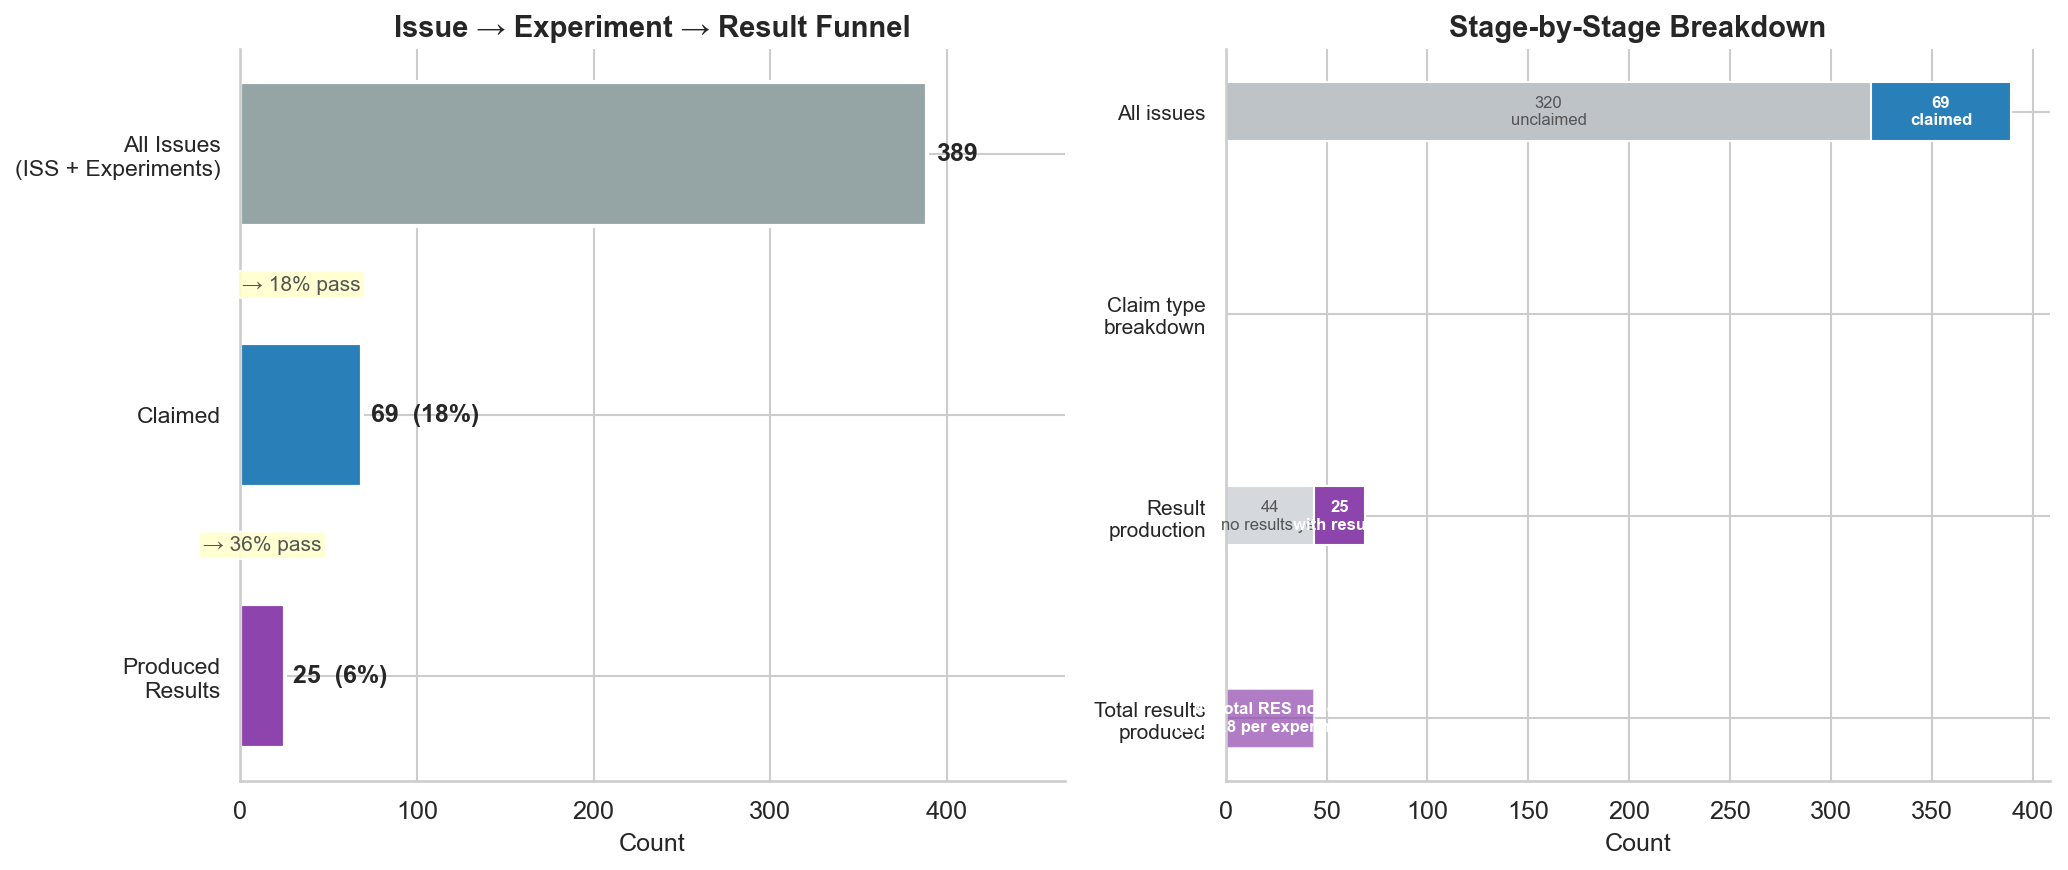

In [16]:
create_funnel_figure(metrics, VIZ_DIR)
Image(filename=str(VIZ_DIR / 'fig5_funnel.png'), width=800)

## Step 2.3: Generate Alluvial/Sankey Diagram

The alluvial diagram shows the flow of ALL claimed experiments through three stages:
1. **Issue Created By** — who posted the original issue
2. **Issue Claimed By** — who claimed and worked on the experiment
3. **Result Created By** — who created the first RES node (for experiments with results)

This reveals the cross-person idea exchange patterns in the lab.

  Saved: /Users/makamats/Repos/node-metrics/output/visualizations/handoff_alluvial.html


  Saved: /Users/makamats/Repos/node-metrics/output/visualizations/handoff_alluvial.png


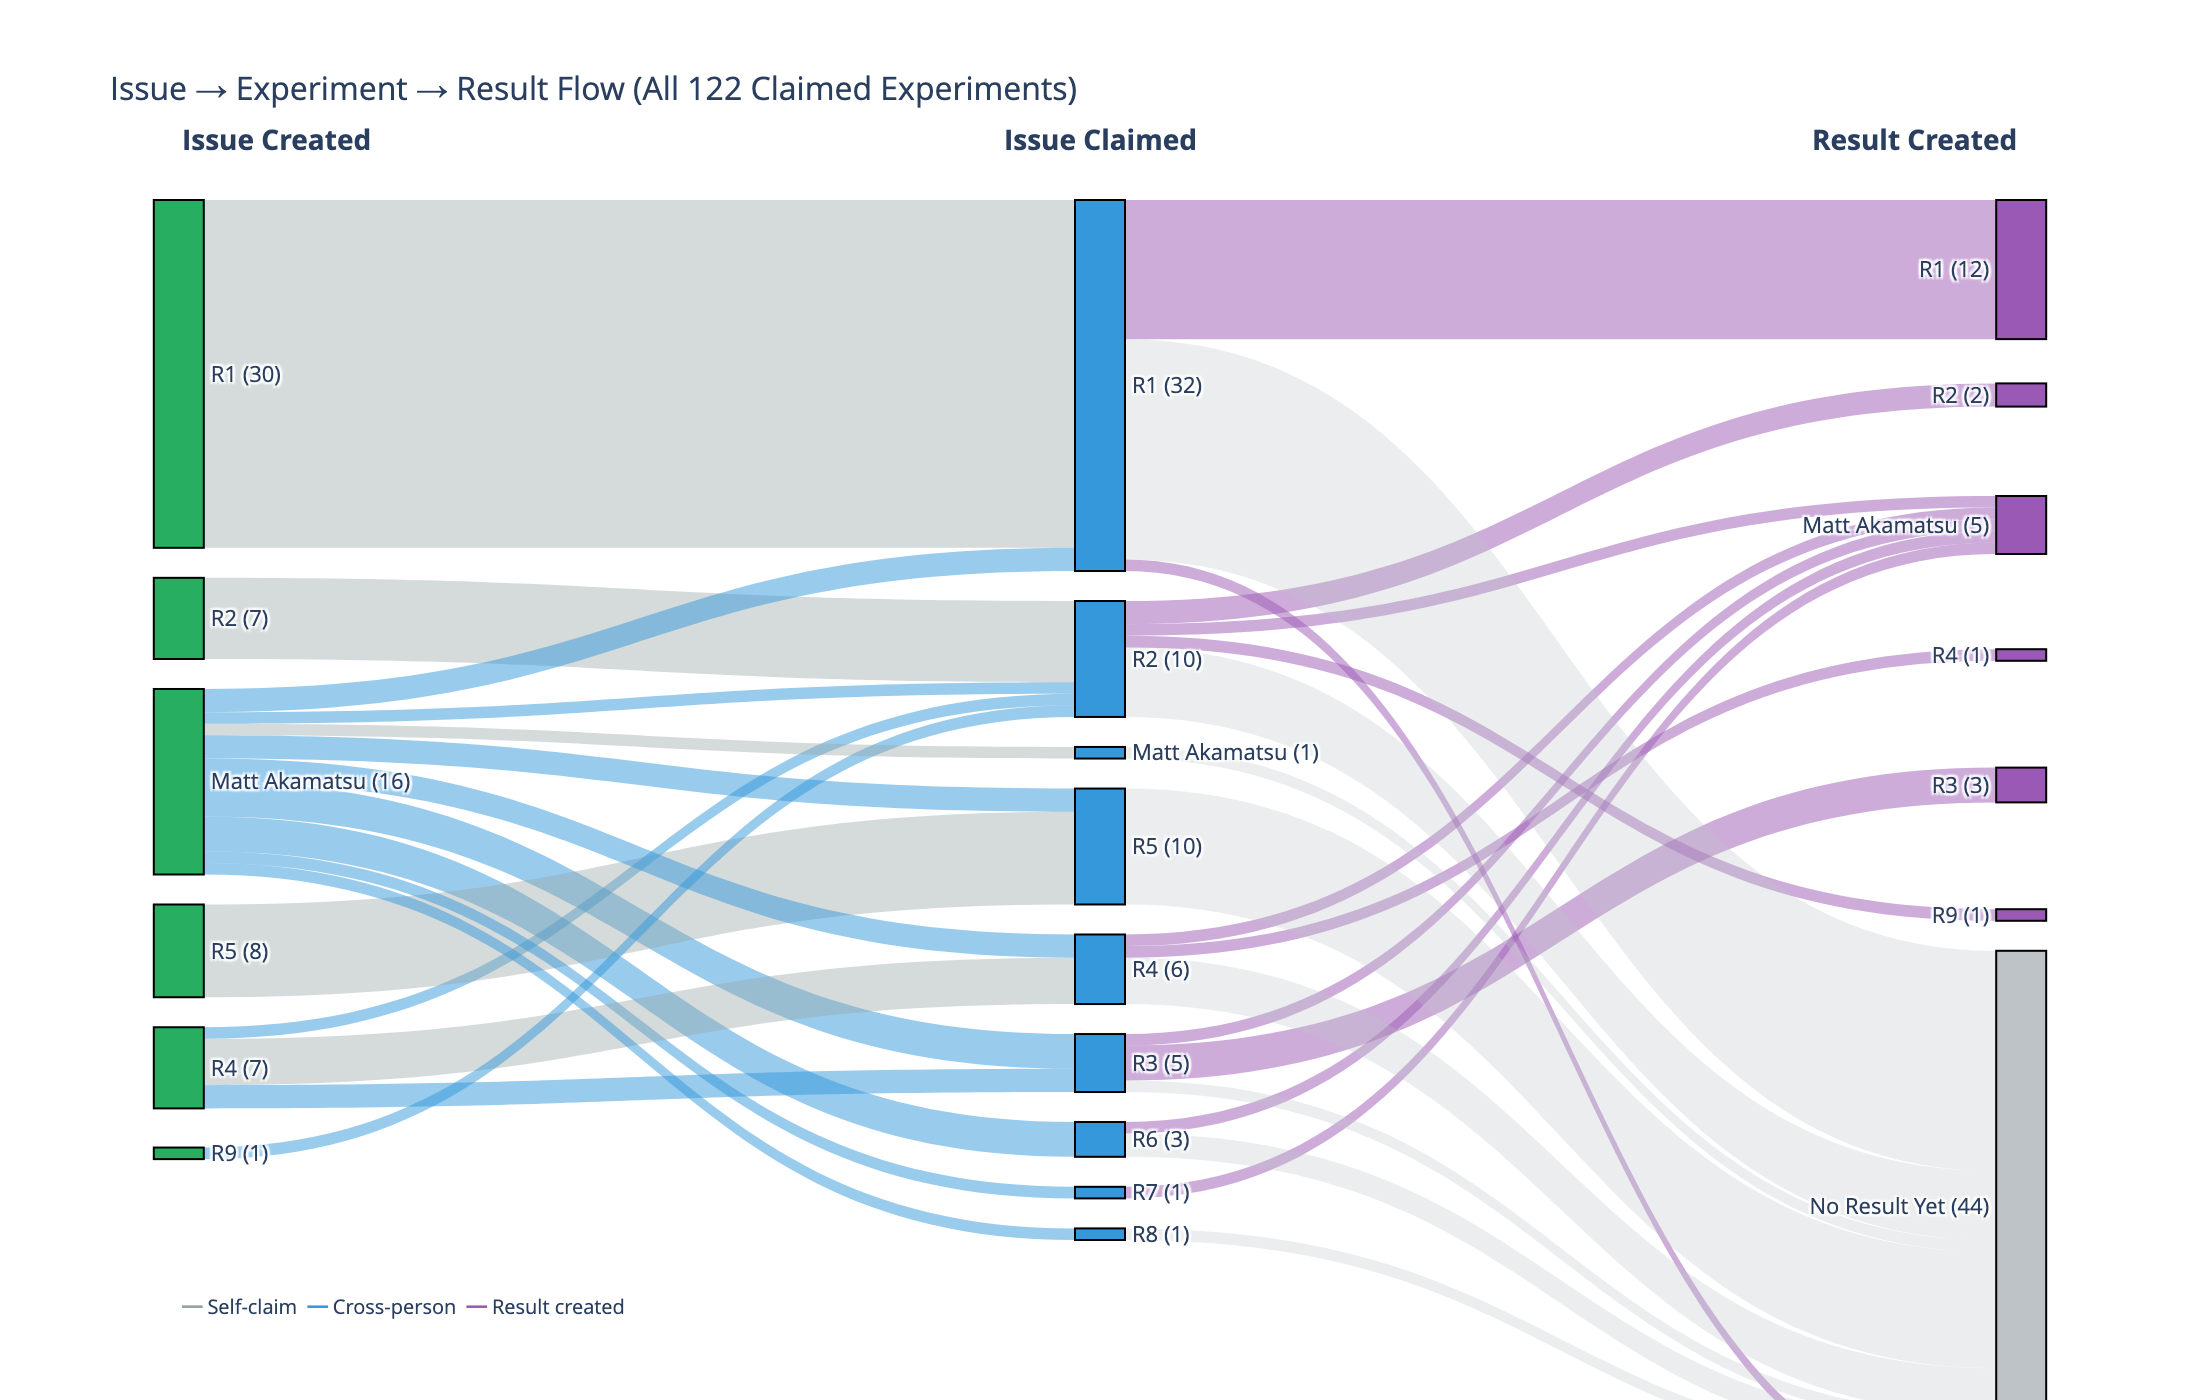


Interactive version: /Users/makamats/Repos/node-metrics/output/visualizations/handoff_alluvial.html


In [17]:
create_alluvial_sankey(metrics, VIZ_DIR)

# Display the static PNG version (interactive HTML also generated)
alluvial_png = VIZ_DIR / 'handoff_alluvial.png'
if alluvial_png.exists():
    display(Image(filename=str(alluvial_png), width=800))
    print(f"\nInteractive version: {VIZ_DIR / 'handoff_alluvial.html'}")
else:
    print("Static PNG not generated — check interactive HTML version.")

## Step 2.4: Generate EVD 5 Evidence Bundle

In [18]:
evd5_bundle_dir = create_evd5_bundle(metrics, OUTPUT_DIR, VIZ_DIR)
print(f"\nBundle contents:")
for f in sorted(evd5_bundle_dir.rglob('*')):
    if f.is_file() and not f.name.startswith('.'):
        print(f"  {f.relative_to(evd5_bundle_dir)} ({f.stat().st_size:,} bytes)")

Evidence bundle created: /Users/makamats/Repos/node-metrics/output/evidence_bundles/evd5-issue-funnel

Bundle contents:
  data/experiment_details.csv (9,377 bytes)
  data/funnel_summary.json (818 bytes)
  docs/evidence_statement.md (2,356 bytes)
  docs/methods_excerpt.md (10,920 bytes)
  evidence.jsonld (5,334 bytes)
  fig5_funnel.png (81,405 bytes)
  ro-crate-metadata.json (3,557 bytes)


---
# Part 3: EVD 7 — Student Onboarding Timeline

**Claim:** All three undergraduate researchers generated an original result from their analysis projects within ~4 months of joining the lab, with two creating a result within ~1 month.

### Note on data sourcing for EVD 7

The student milestone data (`first_day`, `first_experiment`, `first_plot`, `first_res`) was **manually extracted** by reading daily notes exports in `student meeting pages/`. These dates are hardcoded in `src/student_timeline_analysis.py` (lines 29–54) because:

- `first_day` comes from meeting notes, not the discourse graph
- `first_experiment` comes from the first experiment reference in daily notes
- `first_plot` comes from the first linked image in daily notes
- Only `first_res` can be cross-validated against the discourse graph (RES node creation date)

For transparency, we display the hardcoded dates and cross-validate `first_res` against the updated discourse graph.

## Step 3.1: Display Hardcoded Milestone Data

In [19]:
print("Hardcoded milestone data (from student_timeline_analysis.py lines 29-54):\n")
for researcher_id in ['A', 'B', 'C']:
    data = STUDENT_DATA[researcher_id]
    print(f"Researcher {researcher_id}:")
    print(f"  First day:        {data['first_day'].strftime('%Y-%m-%d')}")
    print(f"  First experiment: {data['first_experiment'].strftime('%Y-%m-%d')}")
    print(f"  First plot:       {data['first_plot'].strftime('%Y-%m-%d')}")
    print(f"  First RES:        {data['first_res'].strftime('%Y-%m-%d')}")
    print(f"  Pathway:          {data['pathway']}")
    print()

Hardcoded milestone data (from student_timeline_analysis.py lines 29-54):

Researcher A:
  First day:        2024-02-23
  First experiment: 2024-04-05
  First plot:       2024-06-20
  First RES:        2024-06-27
  Pathway:          Self-directed exploration

Researcher B:
  First day:        2024-10-10
  First experiment: 2024-10-15
  First plot:       2024-10-15
  First RES:        2024-11-26
  Pathway:          Assigned entry project

Researcher C:
  First day:        2025-06-23
  First experiment: 2025-06-30
  First plot:       2025-07-07
  First RES:        2025-07-29
  Pathway:          Direct assignment



In [20]:
milestones = compute_milestones(STUDENT_DATA)
rows = []
for rid in ['A', 'B', 'C']:
    m = milestones[rid]
    rows.append({
        'Researcher': rid,
        'Start Date': m['first_day'],
        'Days to Exp': m['days_to_experiment'],
        'Days to Plot': m['days_to_plot'],
        'Days to RES': m['days_to_res'],
        'Pathway': m['pathway'],
    })
df_milestones = pd.DataFrame(rows)
display(df_milestones)

mean_res = sum(r['Days to RES'] for r in rows) / len(rows)
print(f"\nMean days to RES: {mean_res:.1f}")

,Researcher,Start Date,Days to Exp,Days to Plot,Days to RES,Pathway
0,A,2024-02-23,42,118,125,Self-directed exploration
1,B,2024-10-10,5,5,47,Assigned entry project
2,C,2025-06-23,7,14,36,Direct assignment



Mean days to RES: 69.3


## Step 3.2: Cross-Validate RES Node Creation Dates

The hardcoded `first_res` dates can be partially validated by checking whether the corresponding RES nodes exist in the updated discourse graph and comparing their creation timestamps.

In [21]:
# Map researchers to their known experiment page titles
researcher_experiments = {
    'A': '@analysis/Quantify the percentage of simulated endocytic events that assemble detectable amounts of actin',
    'B': '@analysis/Plot the number of bound Hip1R over time for different Arp2/3 distributions in endocytosis simulations',
    'C': '@analysis/correlate segmented endocytic spots to cell location (apical, basal, lateral) in 3D',
}

print("Cross-validating RES node creation dates from updated discourse graph:\n")
for researcher_id, exp_title in researcher_experiments.items():
    print(f"Researcher {researcher_id}: {exp_title[:60]}...")
    
    # Search RES nodes for references to this experiment
    exp_ref = f'[[{exp_title}]]'.lower()
    # Also try matching by description substring
    exp_desc = exp_title.split('/', 1)[1].lower() if '/' in exp_title else exp_title.lower()
    
    matching_res = []
    for res in jsonld_data['res_nodes']:
        res_title = res.get('title', '').lower()
        if exp_ref in res_title or (len(exp_desc) >= 20 and exp_desc[:20] in res_title):
            created = parse_date(res.get('created'))
            matching_res.append({
                'title': res['title'][:80],
                'created': created,
            })
    
    if matching_res:
        earliest = min(matching_res, key=lambda x: x['created'] if x['created'] else datetime.max)
        hardcoded_date = STUDENT_DATA[researcher_id]['first_res']
        graph_date = earliest['created']
        if graph_date and graph_date.tzinfo:
            graph_date = graph_date.replace(tzinfo=None)
        delta = abs((graph_date - hardcoded_date).days) if graph_date else 'N/A'
        print(f"  Found {len(matching_res)} RES node(s)")
        print(f"  Earliest RES created: {graph_date}")
        print(f"  Hardcoded first_res:  {hardcoded_date}")
        print(f"  Discrepancy:          {delta} day(s)")
    else:
        print(f"  No RES nodes found by title match")
    print()

Cross-validating RES node creation dates from updated discourse graph:

Researcher A: @analysis/Quantify the percentage of simulated endocytic eve...
  Found 5 RES node(s)
  Earliest RES created: 2024-06-28 00:15:20.625000
  Hardcoded first_res:  2024-06-27 00:00:00
  Discrepancy:          1 day(s)

Researcher B: @analysis/Plot the number of bound Hip1R over time for diffe...
  Found 3 RES node(s)
  Earliest RES created: 2024-10-15 19:10:37.616000
  Hardcoded first_res:  2024-11-26 00:00:00
  Discrepancy:          42 day(s)

Researcher C: @analysis/correlate segmented endocytic spots to cell locati...
  No RES nodes found by title match



## Step 3.3: Lab Average Comparison

The lab average time-to-first-result comes from Metric 3 (calculated in Part 1). We compare it to the student researcher averages.

In [22]:
lab_avg_days = time_to_result['avg_days'] if time_to_result['count'] > 0 else 88.3

print(f"Lab average time-to-first-result (updated): {lab_avg_days} days")
print(f"Lab average time-to-first-result (original): 88.3 days")
print()

student_res_days = [milestones[rid]['days_to_res'] for rid in ['A', 'B', 'C']]
student_avg = sum(student_res_days) / len(student_res_days)
print(f"Student average time-to-RES: {student_avg:.1f} days")
for rid in ['A', 'B', 'C']:
    print(f"  Researcher {rid}: {milestones[rid]['days_to_res']} days")
print(f"\nStudents vs lab average: {student_avg:.1f} vs {lab_avg_days} days")
if student_avg < lab_avg_days:
    print(f"  Students are {lab_avg_days - student_avg:.1f} days faster than lab average")

Lab average time-to-first-result (updated): 151.7 days
Lab average time-to-first-result (original): 88.3 days

Student average time-to-RES: 69.3 days
  Researcher A: 125 days
  Researcher B: 47 days
  Researcher C: 36 days

Students vs lab average: 69.3 vs 151.7 days
  Students are 82.4 days faster than lab average


## Step 3.4: Generate Figure 7 — Student Onboarding Timeline

Three versions:
- **Static PNG** (matplotlib): Pin-style timeline with phase bars
- **Interactive HTML** (Plotly): Hover tooltips and zoom
- **Comparison bar chart**: Side-by-side milestone comparison

In [23]:
# Generate all EVD 7 visualizations
create_pin_timeline(STUDENT_DATA, VIZ_DIR / 'fig7_student_timelines.png')
create_pin_timeline_interactive(STUDENT_DATA, VIZ_DIR / 'fig7_student_timelines.html')
create_comparison_bar_chart(STUDENT_DATA, VIZ_DIR / 'student_milestone_comparison.png')
save_milestones_json(STUDENT_DATA, OUTPUT_DIR / 'student_milestones.json')

print("All EVD 7 visualizations generated.")

  Saved: /Users/makamats/Repos/node-metrics/output/visualizations/fig7_student_timelines.png


  Saved: /Users/makamats/Repos/node-metrics/output/visualizations/fig7_student_timelines.html


  Saved: /Users/makamats/Repos/node-metrics/output/visualizations/student_milestone_comparison.png
  Saved: /Users/makamats/Repos/node-metrics/output/student_milestones.json
All EVD 7 visualizations generated.


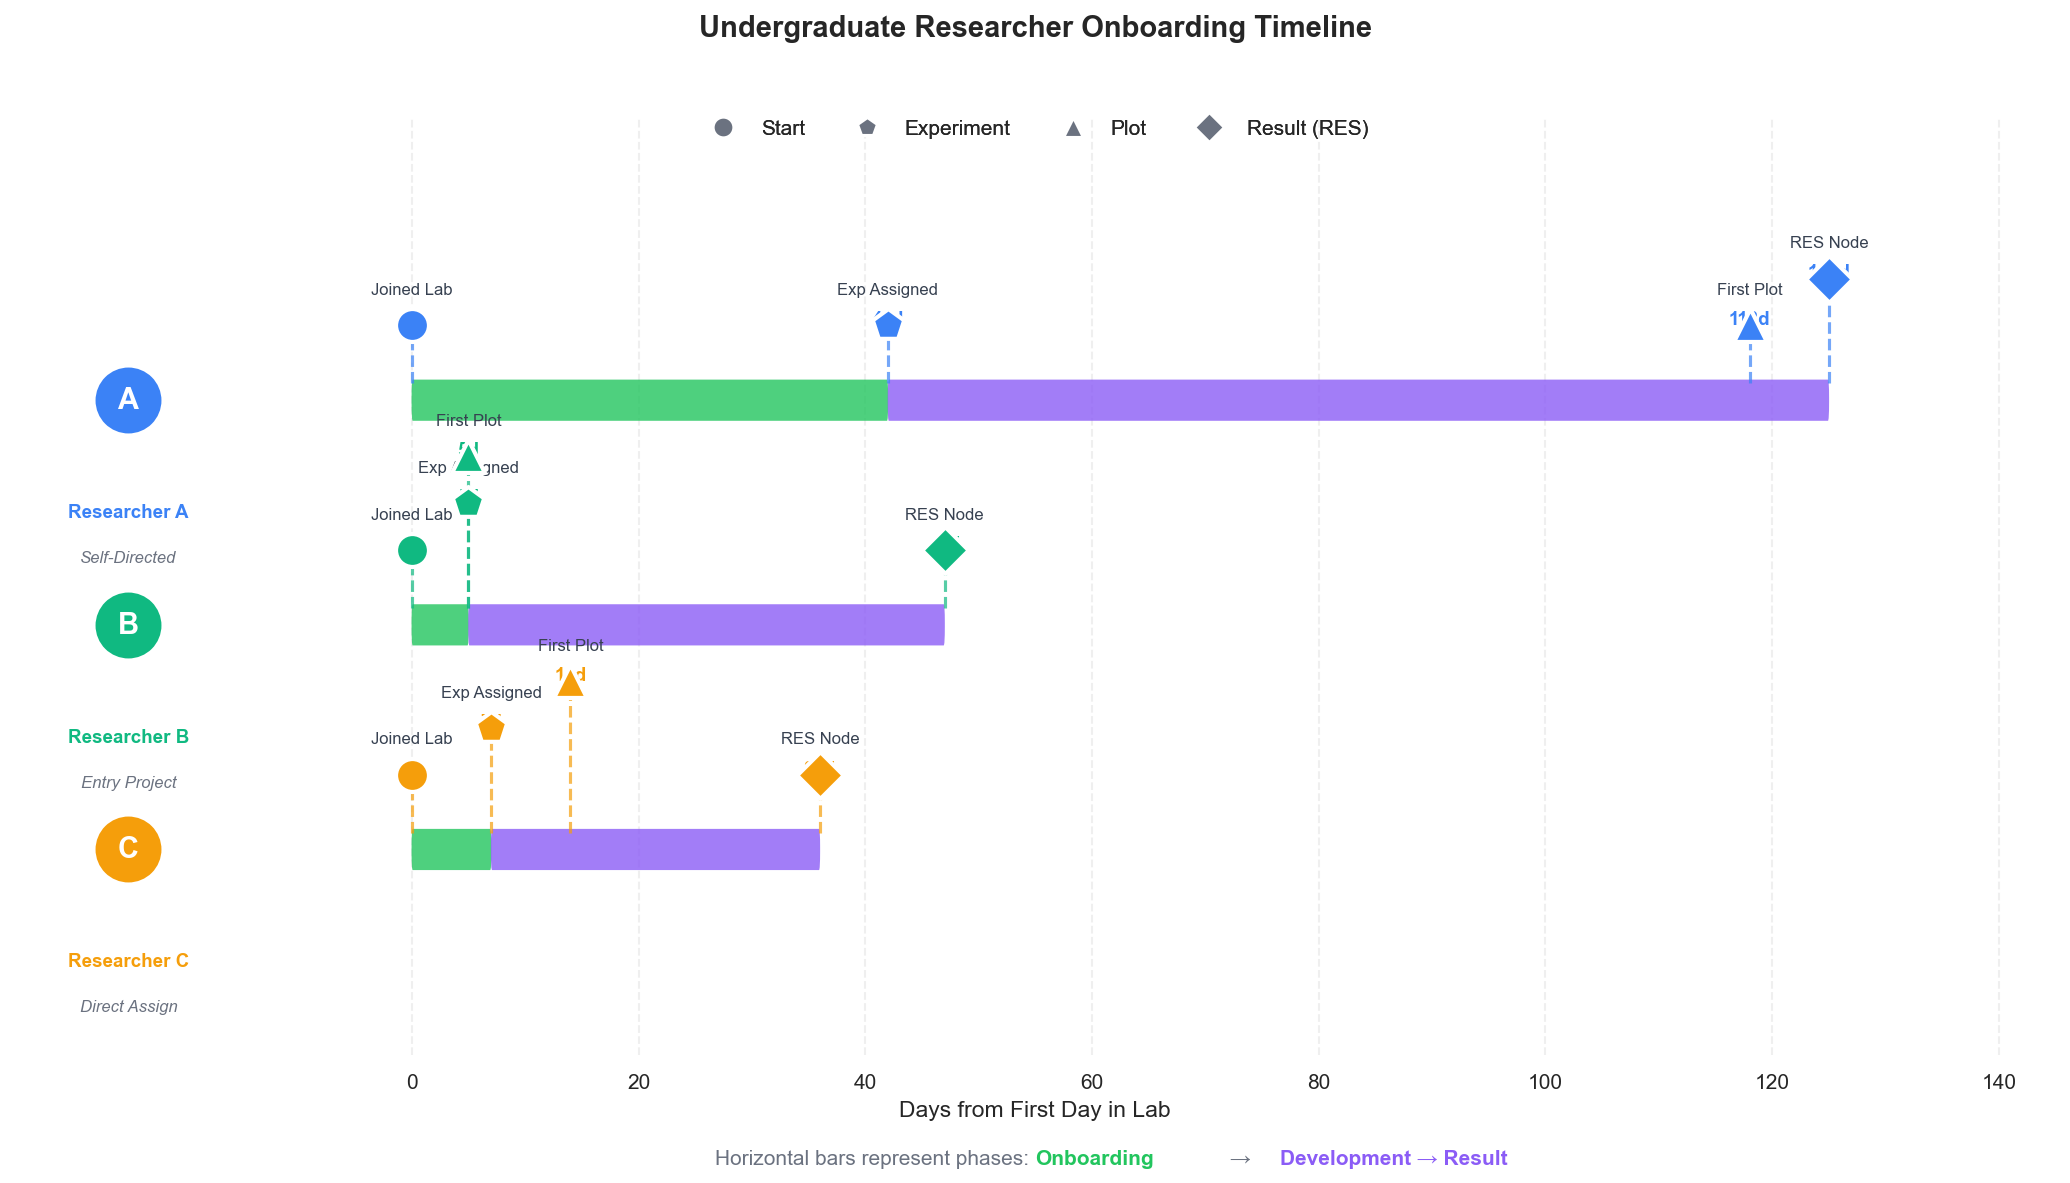

In [24]:
Image(filename=str(VIZ_DIR / 'fig7_student_timelines.png'), width=800)

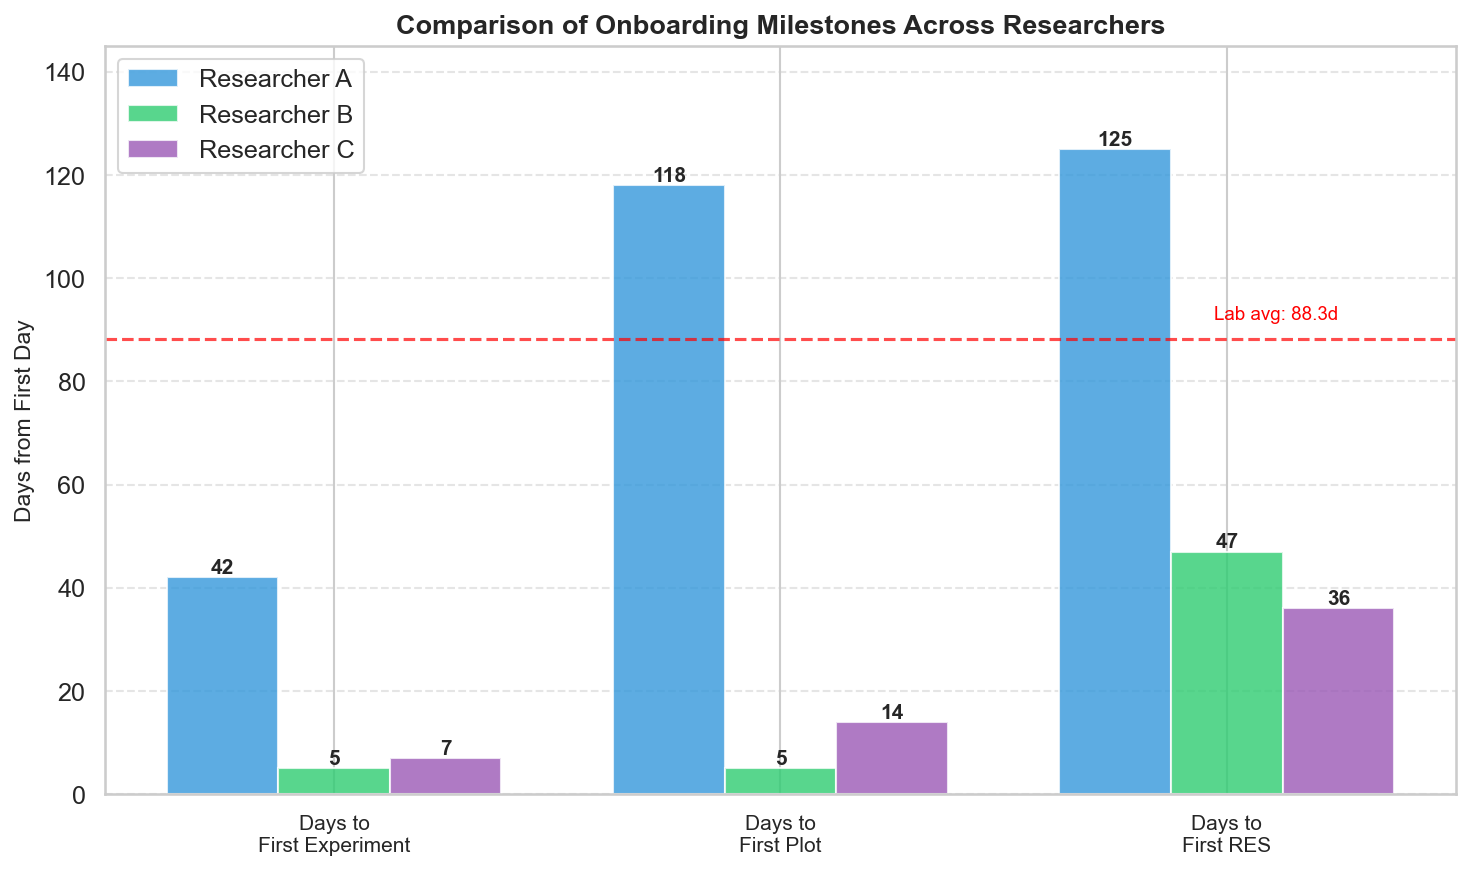

In [25]:
Image(filename=str(VIZ_DIR / 'student_milestone_comparison.png'), width=700)

## Step 3.5: Generate EVD 7 Evidence Bundle

In [26]:
evd7_bundle_dir = create_evd7_bundle(OUTPUT_DIR, VIZ_DIR, metrics=metrics)
print(f"\nBundle contents:")
for f in sorted(evd7_bundle_dir.rglob('*')):
    if f.is_file() and not f.name.startswith('.'):
        print(f"  {f.relative_to(evd7_bundle_dir)} ({f.stat().st_size:,} bytes)")

Evidence bundle created: /Users/makamats/Repos/node-metrics/output/evidence_bundles/evd7-student-onboarding

Bundle contents:
  data/student_milestones.json (693 bytes)
  docs/evidence_statement.md (3,383 bytes)
  evidence.jsonld (4,366 bytes)
  fig7_student_timelines.html (17,223 bytes)
  fig7_student_timelines.png (111,256 bytes)
  ro-crate-metadata.json (2,746 bytes)


---
# Part 4: Summary and Provenance

In [27]:
# Side-by-side comparison of Jan 24 vs Feb 11 values
total_res_updated = sum(d['total_linked_res'] for d in time_to_result['details']) if time_to_result['details'] else 0

comparison = pd.DataFrame([
    {'Metric': 'Total ISS nodes', 'Jan 24, 2026': 312, 'Feb 11, 2026': len(iss_nodes)},
    {'Metric': 'Total experiment pages', 'Jan 24, 2026': 122, 'Feb 11, 2026': len(experiments)},
    {'Metric': 'Total issues', 'Jan 24, 2026': 434, 'Feb 11, 2026': conversion['total_issues']},
    {'Metric': 'Claimed experiments', 'Jan 24, 2026': 127, 'Feb 11, 2026': conversion['total_claimed']},
    {'Metric': 'Conversion rate (%)', 'Jan 24, 2026': 29.3, 'Feb 11, 2026': conversion['conversion_rate_percent']},
    {'Metric': 'Experiments with RES', 'Jan 24, 2026': 48, 'Feb 11, 2026': time_to_result['count']},
    {'Metric': 'Total linked RES nodes', 'Jan 24, 2026': 136, 'Feb 11, 2026': total_res_updated},
    {'Metric': 'Cross-person claims', 'Jan 24, 2026': 19, 'Feb 11, 2026': cross_person['cross_person_count']},
    {'Metric': 'Idea exchange rate (%)', 'Jan 24, 2026': 15.6, 'Feb 11, 2026': cross_person['idea_exchange_rate']},
    {'Metric': 'Lab avg time-to-result (days)', 'Jan 24, 2026': 88.3, 'Feb 11, 2026': time_to_result['avg_days']},
])
comparison['Delta'] = comparison['Feb 11, 2026'] - comparison['Jan 24, 2026']
display(comparison)

# Attribution method distribution
print("\nAttribution method distribution (experiment pages):")
method_counts = Counter(exp.get('attribution_method') for exp in experiments)
for method, count in sorted(method_counts.items(), key=lambda x: -x[1]):
    label = {
        'made_by': 'Made by / Creator / Created by',
        'claimed_by': 'Claimed By',
        'author': 'Author',
        'creator': 'JSON-LD creator (fallback)',
        None: 'No attribution',
    }.get(method, method)
    print(f"  {label}: {count} ({count/len(experiments)*100:.1f}%)")

,Metric,"Jan 24, 2026","Feb 11, 2026",Delta
0,Total ISS nodes,312.0,320.0,8.0
1,Total experiment pages,122.0,173.0,51.0
2,Total issues,434.0,389.0,-45.0
3,Claimed experiments,127.0,69.0,-58.0
4,Conversion rate (%),29.3,17.7,-11.6
5,Experiments with RES,48.0,25.0,-23.0
6,Total linked RES nodes,136.0,44.0,-92.0
7,Cross-person claims,19.0,19.0,0.0
8,Idea exchange rate (%),15.6,27.5,11.9
9,Lab avg time-to-result (days),88.3,151.7,63.4



Attribution method distribution (experiment pages):
  JSON-LD creator (fallback): 104 (60.1%)
  Claimed By: 69 (39.9%)


## Provenance Record

| Field | Value |
|-------|-------|
| Analysis date | 2026-02-11 |
| JSON-LD export | `graph raw data/akamatsulab_discourse-graph-json-LD202602112140.json` |
| Roam JSON export | `graph raw data/akamatsulab-whole-graph-json-2026-02-11-21-45-17.json` |
| Pipeline code | `src/` directory |
| Notebook | `notebooks/evd1_evd7_analysis.ipynb` |
| De-identification | Researcher names anonymized (R1–R11); PI identified |
| Previous analysis | Jan 24–31, 2026 |

In [28]:
# Save full metrics JSON
def json_serializer(obj):
    if isinstance(obj, datetime):
        return obj.isoformat()
    raise TypeError(f"Object of type {type(obj)} is not JSON serializable")

metrics_path = OUTPUT_DIR / 'metrics_data.json'
with open(metrics_path, 'w') as f:
    json.dump(metrics, f, indent=2, default=json_serializer)
print(f"Metrics saved to: {metrics_path}")

Metrics saved to: /Users/makamats/Repos/node-metrics/output/metrics_data.json


## Outputs Generated

This notebook produced or regenerated:

### EVD 1 Bundle (`output/evidence_bundles/evd1-conversion-rate/`)
- `evidence.jsonld` — Canonical metadata
- `ro-crate-metadata.json` — RO-Crate manifest
- `fig1_conversion_rate.png` — Static figure
- `fig1_conversion_rate.html` — Interactive figure
- `data/conversion_data.json` — Aggregated data
- `docs/evidence_statement.md` — Evidence text
- `docs/methods_excerpt.md` — Methods sections

### EVD 5 Bundle (`output/evidence_bundles/evd5-issue-funnel/`)
- `evidence.jsonld` — Canonical metadata
- `ro-crate-metadata.json` — RO-Crate manifest
- `fig5_funnel.png` — Funnel figure
- `data/funnel_summary.json` — Funnel stage data
- `data/experiment_details.csv` — Per-experiment detail rows
- `docs/evidence_statement.md` — Evidence text
- `docs/methods_excerpt.md` — Methods sections

### EVD 7 Bundle (`output/evidence_bundles/evd7-student-onboarding/`)
- `evidence.jsonld` — Canonical metadata
- `ro-crate-metadata.json` — RO-Crate manifest
- `fig7_student_timelines.png` — Static figure
- `data/student_milestones.json` — Milestone data
- `docs/evidence_statement.md` — Evidence text

### Shared Outputs
- `output/metrics_data.json` — Full metrics JSON
- `output/student_milestones.json` — Student milestone data
- `output/visualizations/` — All figures